# Universal Studios Reviews - EDA

## Import Libraries

In [1]:
# data manipulation
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# text data
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
import re
import string

# sentiment analysis
from textblob import TextBlob
from wordcloud import WordCloud
from PIL import Image

## Data Wrangling

### Read Data

In [2]:
df = pd.read_csv('universal_studio_branches.csv', encoding = 'UTF-8')
df.head()

,reviewer,rating,written_date,title,review_text,branch
0,Kelly B,2.0,"May 30, 2021",Universal is a complete Disaster - stick with ...,We went to Universal over Memorial Day weekend...,Universal Studios Florida
1,Jon,1.0,"May 30, 2021",Food is hard to get.,The food service is horrible. I’m not reviewin...,Universal Studios Florida
2,Nerdy P,2.0,"May 30, 2021",Disappointed,I booked this vacation mainly to ride Hagrid m...,Universal Studios Florida
3,ran101278,4.0,"May 29, 2021",My opinion,When a person tries the test seat for the ride...,Universal Studios Florida
4,tammies20132015,5.0,"May 28, 2021",The Bourne Stuntacular...MUST SEE,"Ok, I can't stress enough to anyone and everyo...",Universal Studios Florida


In [3]:
df.isnull().sum()

reviewer        0
rating          0
written_date    0
title           0
review_text     0
branch          0
dtype: int64

### Change Data Type

In [4]:
df.dtypes

reviewer         object
rating          float64
written_date     object
title            object
review_text      object
branch           object
dtype: object

From the information above we should change data type of `written_date` into datetime64

In [5]:
df['written_date'] = pd.to_datetime(df['written_date'])
df.dtypes

reviewer                object
rating                 float64
written_date    datetime64[ns]
title                   object
review_text             object
branch                  object
dtype: object

In [6]:
df.nunique()

reviewer        44086
rating              5
written_date     4276
title           37522
review_text     50847
branch              3
dtype: int64

Also we need to change `branch` into category data type

In [7]:
df['branch'].unique()

array(['Universal Studios Florida', 'Universal Studios Japan',
       'Universal Studios Singapore'], dtype=object)

In [8]:
df['branch'] = df['branch'].astype('category')
df.dtypes

reviewer                object
rating                 float64
written_date    datetime64[ns]
title                   object
review_text             object
branch                category
dtype: object

### Removing Duplicates Data

In [9]:
df.shape

(50904, 6)

**We have 50,904 rows and 6 columns.**<br><br>
For the further analysing the duplicate data, in this case is `review_text` indicate that they also contain the same information in other columns too. So wee need to drop the duplicate and keeping first.

In [10]:
df.drop_duplicates(subset='review_text', inplace=True, keep='first')
df.shape

(50847, 6)

### Data Summary

In [11]:
print ("Number of Rows     :" ,df.shape[0])
print ("Number of Columns  :" ,df.shape[1])
print ("\nFeatures         :\n" ,list(df.columns))
print ("\nMissing values   :", df.isnull().sum().sum())
print ("\nUnique values    :\n",df.nunique())
print ("\nBranches Reviews :\n",df['branch'].value_counts())

Number of Rows     : 50847
Number of Columns  : 6

Features         :
 ['reviewer', 'rating', 'written_date', 'title', 'review_text', 'branch']

Missing values   : 0

Unique values    :
 reviewer        44082
rating              5
written_date     4276
title           37517
review_text     50847
branch              3
dtype: int64

Branches Reviews :
 Universal Studios Florida      30582
Universal Studios Singapore    15738
Universal Studios Japan         4527
Name: branch, dtype: int64


There is some bias in the data to Branches feature value counts aren't fairly distributed

## Feature Engineering

### Get Period Information of `written_date`

In [12]:
df['quarter'] = df['written_date'].dt.to_period('Q')
df.head()

,reviewer,rating,written_date,title,review_text,branch,quarter
0,Kelly B,2.0,2021-05-30,Universal is a complete Disaster - stick with ...,We went to Universal over Memorial Day weekend...,Universal Studios Florida,2021Q2
1,Jon,1.0,2021-05-30,Food is hard to get.,The food service is horrible. I’m not reviewin...,Universal Studios Florida,2021Q2
2,Nerdy P,2.0,2021-05-30,Disappointed,I booked this vacation mainly to ride Hagrid m...,Universal Studios Florida,2021Q2
3,ran101278,4.0,2021-05-29,My opinion,When a person tries the test seat for the ride...,Universal Studios Florida,2021Q2
4,tammies20132015,5.0,2021-05-28,The Bourne Stuntacular...MUST SEE,"Ok, I can't stress enough to anyone and everyo...",Universal Studios Florida,2021Q2


### Get Review Length Feature of `written_text`

In [13]:
df['review_text'].values[4:5]

array(["Ok, I can't stress enough to anyone and everyone... if you go to Universal Studios Orlando... make sure you take the time to go see The Bourne Stuntacular...I had to watch it 3xs and it wasn't enough. I never knew who Jason Bourne was... but now I will be buying the movies. This was absolutely awesome, amazing and 100% worth the entire cost of the trip by itself. So worth the wait and every time I went it was packed. I would have passed it up thinking it was nothing WRONG!!!! ...DONT MISS THIS!!!!"],
      dtype=object)

### Get Sentiment Analysis Feature

Let's clean the `review_text` column first by define a function:

In [14]:
def text_clean(text):
    # case folding
    text = text.lower()
    
    ## Decontract text            
    # specific
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"won\’t", "will not", text)
    text = re.sub(r"can\’t", "can not", text)
    text = re.sub(r"\'t've", " not have", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'clock", "f the clock", text)
    text = re.sub(r"\'cause", " because", text)
    
    # general
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"n\’t", " not", text)
    text = re.sub(r"\’re", " are", text)
    text = re.sub(r"\’s", " is", text)
    text = re.sub(r"\’d", " would", text)
    text = re.sub(r"\’ll", " will", text)
    text = re.sub(r"\’t", " not", text)
    text = re.sub(r"\’ve", " have", text)
    text = re.sub(r"\’m", " am", text)
    
    # remove all puctuation
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # text = re.sub('\w*\d\w*', '', text) #remove digit/number
    
    # remove all special characters
    text = re.sub(r'\W', ' ', text)

    # remove break
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    
    # remove prefixed 'b'
    text = re.sub(r'^b\s+', '', text)
    
    # substituting multiple spaces with single space
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    
    return text

In [15]:
df_text = pd.DataFrame()
df_text['clean_review_text'] = df['review_text'].apply(lambda x: text_clean(x))

Let's check before and after cleansing

In [16]:
df.loc[44,'review_text']

'✅ $850💵 + ⏰ hours of high heat 91 degrees🔥 & 😷☀️. We were shocked to be in long lines walking about 7.5 miles for the day masked up! Like sheep 🐑 being threatened constantly with loud speaker 🔈announcements demanding no drinking 🥤or eating while walking 🚶\u200d♀️& maintain social distancing, wearing a mask at all times or being 👢booted from the park. I saw kids 👆touching all handrails and then putting hands in their parents cups eating ice and then the parents gulping down the remainder(at $10 per beverage can you blame them) 🤷\u200d♂️ confused I do thousands of people show up to spend 💰💰💰💰💰💰if they are paranoid of public places! Universal Studios is a germs 🦠 paradise! They also pray on people’s wallets with the nifty reservation system it allows them to supply and demand fast passes from $80 extra to $249 demanding on all the variables they control! We despised being ordered around with lousy customer service! Constant loud interruptions🛑 during the rides 🎢demanding guests wear a ma

In [17]:
df_text.loc[44,'clean_review_text']

' 850 hours of high heat 91 degrees we were shocked to be in long lines walking about 75 miles for the day masked up like sheep being threatened constantly with loud speaker announcements demanding no drinking or eating while walking maintain social distancing wearing a mask at all times or being booted from the park i saw kids touching all handrails and then putting hands in their parents cups eating ice and then the parents gulping down the remainderat 10 per beverage can you blame them confused i do thousands of people show up to spend if they are paranoid of public places universal studios is a germs paradise they also pray on people is wallets with the nifty reservation system it allows them to supply and demand fast passes from 80 extra to 249 demanding on all the variables they control we despised being ordered around with lousy customer service constant loud interruptions during the rides demanding guests wear a mask save yourself the money headaches and do not go it is ridicul

**Sentiment Analysis**<br>
Define function to get the subjectivity and polarity of text

In [18]:
def getSubjectivity(text):
   return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
   return  TextBlob(text).sentiment.polarity

create column subjectivity and polarity and sentiment analysis

In [19]:
df_text['subjectivity'] = df_text['clean_review_text'].apply(getSubjectivity)
df_text['polarity'] = df_text['clean_review_text'].apply(getPolarity)
def getsentiment(score):
 if score < 0:
  return 'negative'
 elif score == 0:
  return 'neutral'
 else:
  return 'positive'
df_text['sentiment'] = df_text['polarity'].apply(getsentiment)
df_text.head()

,clean_review_text,subjectivity,polarity,sentiment
0,we went to universal over memorial day weekend...,0.411574,-0.065278,negative
1,the food service is horrible i am not reviewin...,0.425000,-0.262500,negative
2,i booked this vacation mainly to ride hagrid m...,0.494771,-0.004259,negative
3,when a person tries the test seat for the ride...,0.380000,0.010000,positive
4,ok i can not stress enough to anyone and every...,0.546717,0.245455,positive


In [20]:
df_text['sentiment'].value_counts()

positive    46936
negative     3598
neutral       313
Name: sentiment, dtype: int64

Beside, assume that rating below 3.0 is 'negative'

In [21]:
df['sentiment'] = df_text['sentiment']
df['sentiment'] = df['rating'].apply(lambda x: 'negative' if x<3.0 else np.nan)
df['sentiment'] = df['sentiment'].fillna(df_text['sentiment'])
df.head()

,reviewer,rating,written_date,title,review_text,branch,quarter,sentiment
0,Kelly B,2.0,2021-05-30,Universal is a complete Disaster - stick with ...,We went to Universal over Memorial Day weekend...,Universal Studios Florida,2021Q2,negative
1,Jon,1.0,2021-05-30,Food is hard to get.,The food service is horrible. I’m not reviewin...,Universal Studios Florida,2021Q2,negative
2,Nerdy P,2.0,2021-05-30,Disappointed,I booked this vacation mainly to ride Hagrid m...,Universal Studios Florida,2021Q2,negative
3,ran101278,4.0,2021-05-29,My opinion,When a person tries the test seat for the ride...,Universal Studios Florida,2021Q2,positive
4,tammies20132015,5.0,2021-05-28,The Bourne Stuntacular...MUST SEE,"Ok, I can't stress enough to anyone and everyo...",Universal Studios Florida,2021Q2,positive


In [22]:
df['sentiment'].value_counts()

positive    44587
negative     5987
neutral       273
Name: sentiment, dtype: int64

## Data Analysis and Visualization

### Number of Reviews by Visitors of Universal Studios Branches

In [23]:
df.dtypes

reviewer                object
rating                 float64
written_date    datetime64[ns]
title                   object
review_text             object
branch                category
quarter          period[Q-DEC]
sentiment               object
dtype: object

In [24]:
df[['sentiment','quarter']] = df[['sentiment','quarter']].astype('category')

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50847 entries, 0 to 50903
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   reviewer      50847 non-null  object        
 1   rating        50847 non-null  float64       
 2   written_date  50847 non-null  datetime64[ns]
 3   title         50847 non-null  object        
 4   review_text   50847 non-null  object        
 5   branch        50847 non-null  category      
 6   quarter       50847 non-null  category      
 7   sentiment     50847 non-null  category      
dtypes: category(3), datetime64[ns](1), float64(1), object(3)
memory usage: 5.0+ MB


In [26]:
branch_count = df['branch'].value_counts()
branch_count.to_frame()

,branch
Universal Studios Florida,30582
Universal Studios Singapore,15738
Universal Studios Japan,4527


Text(0, 0.5, 'Number of Reviews')

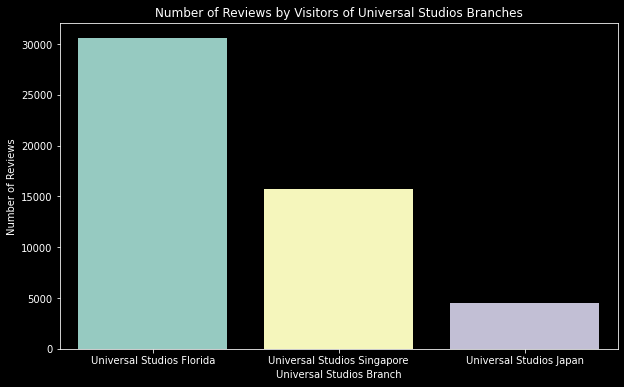

In [27]:
plt.figure(figsize=(10,6))
plt.title('Number of Reviews by Visitors of Universal Studios Branches')
sns.countplot(data=df, x='branch', order=['Universal Studios Florida', 'Universal Studios Singapore', 'Universal Studios Japan'])
plt.xlabel('Universal Studios Branch')
plt.ylabel('Number of Reviews')

> Highest number of visitors at Universal Studios Florida compare with two other branches.

### Number of Reviews by Visitors of Universal Studios Branches per Year

In [28]:
df['year'] = df['written_date'].dt.year.astype('int64')
df.head()

,reviewer,rating,written_date,title,review_text,branch,quarter,sentiment,year
0,Kelly B,2.0,2021-05-30,Universal is a complete Disaster - stick with ...,We went to Universal over Memorial Day weekend...,Universal Studios Florida,2021Q2,negative,2021
1,Jon,1.0,2021-05-30,Food is hard to get.,The food service is horrible. I’m not reviewin...,Universal Studios Florida,2021Q2,negative,2021
2,Nerdy P,2.0,2021-05-30,Disappointed,I booked this vacation mainly to ride Hagrid m...,Universal Studios Florida,2021Q2,negative,2021
3,ran101278,4.0,2021-05-29,My opinion,When a person tries the test seat for the ride...,Universal Studios Florida,2021Q2,positive,2021
4,tammies20132015,5.0,2021-05-28,The Bourne Stuntacular...MUST SEE,"Ok, I can't stress enough to anyone and everyo...",Universal Studios Florida,2021Q2,positive,2021


<AxesSubplot:title={'center':'Number of Reviews by Visitors of Universal Studios Branches per Year'}, xlabel='year', ylabel='count'>

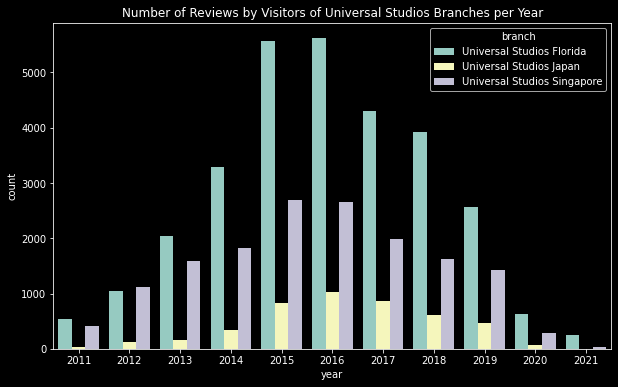

In [29]:
plt.figure(figsize=(10,6))
plt.title('Number of Reviews by Visitors of Universal Studios Branches per Year')
sns.countplot(data=df[df['year']>2010], x='year', hue='branch')

>From the visualization above, we can see that from 2011 there was an increase in the number of visitors until 2016. After that, the number of visitors decreased drastically in 2020, considering that this year covid pandemic was spreading all over the world.

### Number of Rating per Year

In [30]:
rates_year=df[df['year']>2010].pivot_table(
    index='year',
    columns='rating',
    values='branch',
    aggfunc='count'
).reset_index().melt(id_vars='year')

<AxesSubplot:title={'center':'Number of Rating per Year'}, xlabel='year', ylabel='value'>

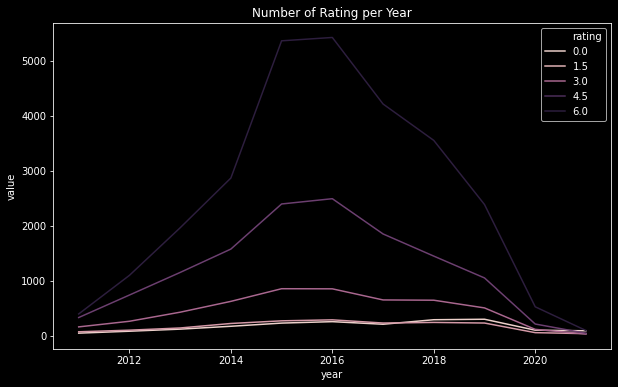

In [31]:
plt.figure(figsize=(10,6))
plt.title('Number of Rating per Year')
sns.lineplot(data= rates_year, x='year', y='value', hue='rating')

> From the visualization above, we can see that many reviewers gave 5 stars. This means that the average Universal Studio visitor is satisfied with their visit by giving a 5 rating.

### Number of Rating per Branch

<AxesSubplot:title={'center':'Number of Rating per Branch'}, xlabel='branch', ylabel='rating'>

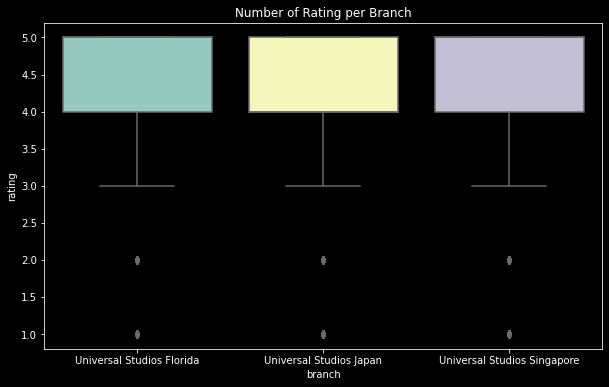

In [32]:
plt.figure(figsize=(10,6))
plt.title('Number of Rating per Branch')
sns.boxplot(data=df, x='branch', y='rating')

### Number of Sentiment per Branch

<AxesSubplot:title={'center':'Number of Sentiment per Branch'}, xlabel='branch', ylabel='count'>

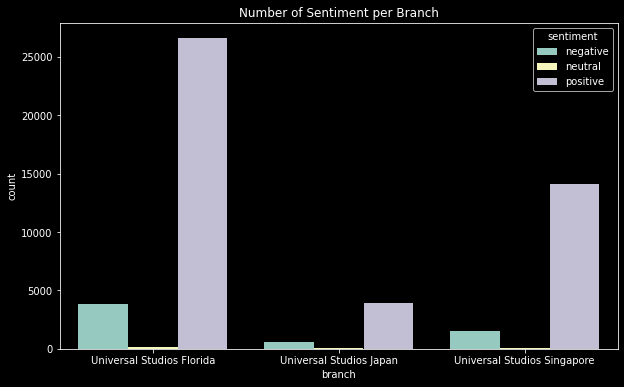

In [33]:
plt.figure(figsize=(10,6))
plt.title('Number of Sentiment per Branch')
sns.countplot(data=df, x='branch', hue='sentiment')

### Sentiment Percentage per Branch

In [34]:
sentiment_percent=pd.crosstab(
    index=df['sentiment'],
    columns=df['branch'],
    normalize='columns'
).round(2)
sentiment_percent

branch,Universal Studios Florida,Universal Studios Japan,Universal Studios Singapore
sentiment,,,
negative,0.13,0.13,0.10
neutral,0.00,0.01,0.01
positive,0.87,0.86,0.90


From the information above we can conclude that, the reviews given to Universal Studio are mostly positive reviews from all three branches.

## Sentiment in Reviews

In [35]:
df['clean_review_text']=df_text['clean_review_text']

**Positive Review**

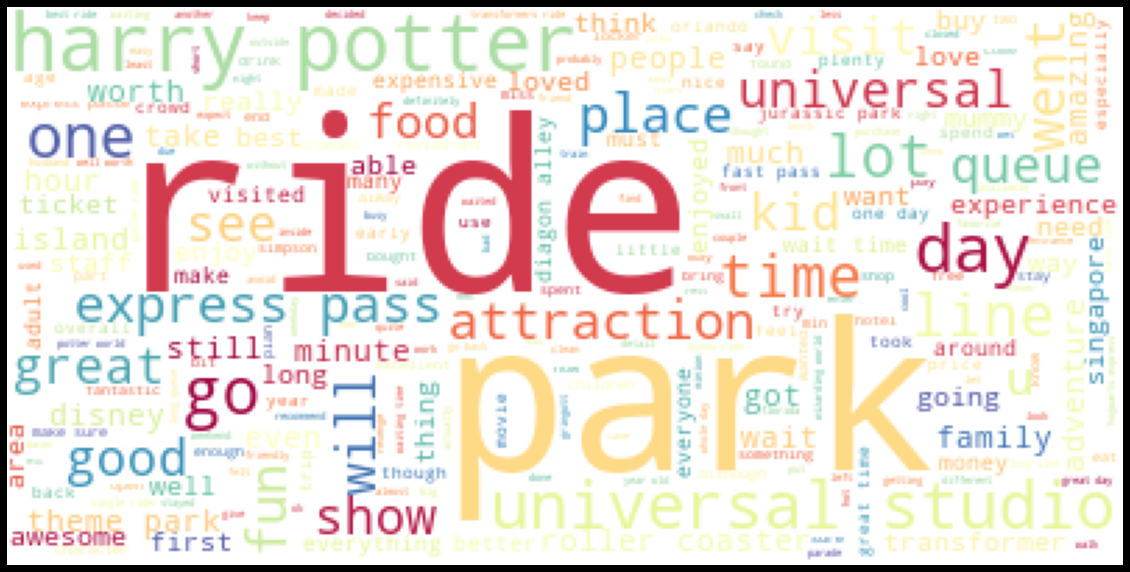

In [36]:
positif_review=df[df['sentiment']=='positive']
review_text = ' '.join(insul for insul in positif_review['clean_review_text'])
word_cloud = WordCloud(
    background_color='white',
    mode='RGB',
    max_words=1000,
    random_state=1,
    colormap='Spectral'
)
word_cloud.generate(review_text)
plt.figure(figsize=(20, 20))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

**Negative Reviews**

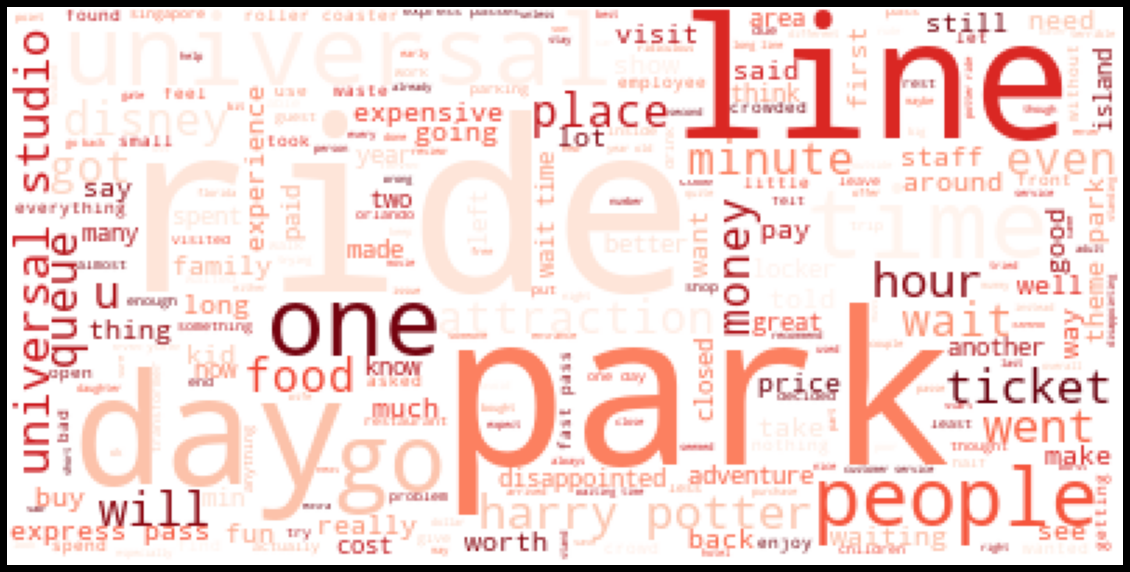

In [37]:
negative_review=df[df['sentiment']=='negative']
review_text = ' '.join(insul for insul in negative_review['clean_review_text'])
word_cloud = WordCloud(
    background_color='white',
    mode='RGB',
    max_words=1000,
    random_state=1,
    colormap='Reds'
)
word_cloud.generate(review_text)
plt.figure(figsize=(20, 20))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

## Word in Negative Review

In the cell below we will segment the words in the negative review text. Using library from `SnowballStemmer` from `nltk.stem.snowball` we will use english language ofcourse. For the corpus we will use `en_core_web_lg` and `en_core_web_sm` from `spacy` library.

- `spacy` is library for advaced Natural Language Processing (NLP) in Python. In this context we used spacy to build information extraction. We use entiti linking to disambiguating textual entities to unique identifiers in a knowledge base.
- We've downloaded and installed a trained pipeline called `en_core_web_sm`, we can load it via `spacy.load`. This will return a language object containing all components and data needed to process text. We usually call it `nlp`. Even though split into individual words and annotated, it still holds all information of the original text. 


In [38]:
# negative_review=negative_review['clean_review_text'].drop_duplicates()

# all_sentences=[]
# for word in negative_review:
#     all_sentences.append(word)
    
# lines=list()
# for line in all_sentences:
#     words=line.split()
#     for w in words:
#         lines.append(w)
        
# #==================

# lines = [re.sub(r'[^A-Za-z0-9]+', '', x) for x in lines]
# lines
# #==================

# lines2 = []
# for word in lines:
#     if word != '':
#         lines2.append(word)
# #==================
# from nltk.stem.snowball import SnowballStemmer
# s_stemmer = SnowballStemmer(language='english')

# stem = []
# for word in lines2:
#     stem.append(s_stemmer.stem(word))
# #==================
# import spacy
# nlp = spacy.load('en_core_web_lg')
# stem2 = []

# for word in stem:
#     if word not in nlp.Defaults.stop_words:
#         stem2.append(word)
# #==================
# df_word = pd.DataFrame(stem2,columns=['name'])
# df_word=df_word['name'].value_counts()[:20,]
# #==================
# from spacy import displacy
# from collections import Counter
# import en_core_web_sm
# nlp = en_core_web_sm.load()
# #==================
# def show_ents(doc):
#     if doc.ents:
#         for ent in doc.ents:
#             print(ent.text + ' - ' + ent.label_ + ' - ' + str(spacy.explain(ent.label_)))
# #==================
# nlp = spacy.load('en_core_web_sm') 
# nlp.max_length = 20000000
# #==================
# str1 = " " 
# stem2 = str1.join(lines2)

# stem2 = nlp(stem2)
# label = [(X.text, X.label_) for X in stem2.ents]
# df_words = pd.DataFrame(label, columns = ['Word','Entity'])
# df_words.to_csv('word_entity.csv')

In [39]:
word_entity = pd.read_csv('word_entity.csv')
word_entity.drop(columns=['Unnamed: 0'], inplace=True)
word_entity.head()

,Word,Entity
0,about forty minutes,TIME
1,2park,CARDINAL
2,nearly 2 hours,TIME
3,a full hour,TIME
4,two hours,TIME


In [40]:
word_entity['Entity'].value_counts()

CARDINAL    11098
DATE         6179
TIME         5578
ORDINAL      1599
MONEY         388
QUANTITY      260
GPE            88
NORP           53
PRODUCT        26
PERCENT        21
ORG            15
PERSON         12
FAC             3
LOC             3
Name: Entity, dtype: int64

### Time Words

In [41]:
time = word_entity[word_entity['Entity']=='TIME']['Word'].value_counts().head(10)

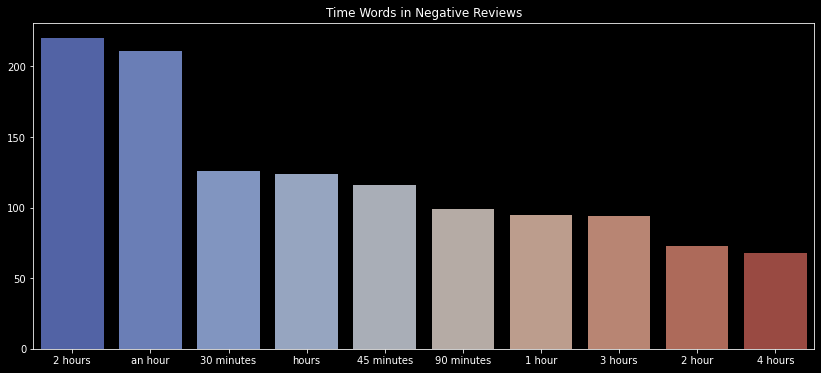

In [42]:
plt.figure(figsize=(14,6))
time_plot = sns.barplot(x=time.index, y=time.values, alpha=0.8, palette='coolwarm')
plt.title('Time Words in Negative Reviews')
plt.show()

In [43]:
df_copy_text = df_text.copy()
df_copy_text = df_copy_text.drop(columns=['subjectivity', 'polarity'])

In [44]:
df_copy_text['time_count'] = df_copy_text['clean_review_text'].apply(lambda word:word.count('2 hours'))
df_time_entity = df_copy_text[df_copy_text['time_count']>0].sort_values(by='time_count', ascending=False).head(10)

**Check "2 hours" in Negative Reviews**

In [45]:
print(df_time_entity['clean_review_text'].values[0:1])

['i recently travelled to florida with my son 15 and nephew 14 to universal orlando the boys wanted to go to hhn so i surprised them with tickets when we arrived we did three houses pretty quick 23 hours and they were good we really enjoyed the street actors who scared us and were amazed at the makeup and costumes then we hit the busy side of the park to see the other houses we stood in line for 2 hours to get into one house and after 2 hours it is hard to remember you are having fun there were so many people who bought an express pass that those of us without were really stuck we finally gave up when all the wait signs said 152 hour wait the line we waited in for 2 hours had a 1 hour wait time posted when we entered i am glad we did not spend full price on these tickets as it would have set a bad tone for our vacation i am also surprised at how universal seems to push alcohol things we liked it is a fun evening at 3540 the houses costumes makeup is great and scary things we disliked l

In [46]:
print(df_time_entity['clean_review_text'].values[1:2])

['glad i did not wait in a line for this the forbidden journey was interesting it was far from wow cmon a 3 d motion simulation often grainy blurry and too fast to appreciate why would anyone wait more than an hour for this i do no know flight of hippogriff ride ok for the family but again no real connection to the story dragon challenge is a repainted older roller coaster big deal the biggest farse was olivanders wand shop wait 112 hours to be among 30 to enter at a time a guy dressed up on a ladder comes down picks one kid and goes through 3 wands selecting one that picks this kid so he gets his free then they usher you all into the store so everyone can buy for 30 their own wand what a great deal stay away from this waste of time the sweet shop across the way sells all manner of candy including the famouse chocolate frogs 10 buys you a chunk small shaped frog made of the worst chocolate you ever tasted my 15 yr old and 12 year old shared one took a nipple each and threw the remainde

>**From the review above we knew that the entitity "2 hours" means time visitor waiting in the lines. This is made them to write negative reviews.**

### Money Words

In [47]:
money = word_entity[word_entity['Entity']=='MONEY']['Word'].value_counts().head(10)
money

hundreds of dollars     20
thousands of dollars    11
80 dollars               6
25 dollars               5
100 dollars              5
1000 dollars             5
50 dollars               5
2 dollars                5
4 dollars                4
200 yen                  4
Name: Word, dtype: int64

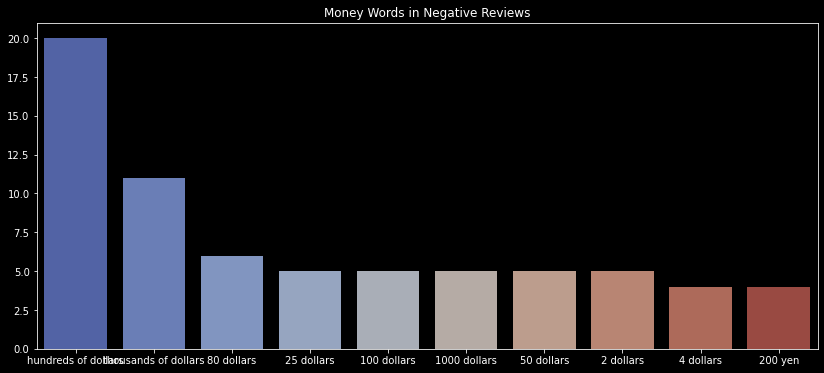

In [48]:
plt.figure(figsize=(14,6))
money_plot = sns.barplot(x=money.index, y=money.values, alpha=0.8, palette='coolwarm')
plt.title('Money Words in Negative Reviews')
plt.show()

**Check "hundreds of dollars" in negative review**

In [49]:
df_copy_text['money_count'] = df_copy_text['clean_review_text'].apply(lambda word:word.count('hundreds of dollars'))
df_money_entity = df_copy_text[df_copy_text['money_count']>0].sort_values(by='money_count', ascending=False).head(10)
df_money_entity

,clean_review_text,sentiment,time_count,money_count
8691,i would never write a negative review of any p...,negative,0,3
4246,let is be serious harry potter is the boy who ...,positive,0,2
4118,i want to love universal i really do however w...,positive,0,2
3632,beware book your flight hotel and park tickets...,positive,0,1
18858,we booked the resort package at cabana bay res...,positive,0,1
34397,unlike disney who has worked to identify creat...,negative,0,1
30477,my family purchased the annual power pass whic...,positive,0,1
27747,i used to enjoy universal more than disney bec...,positive,1,1
26498,i was excited to do a different park while vis...,positive,0,1
25084,both parks are outstanding but pay attention t...,positive,0,1


In [50]:
df_money_entity['clean_review_text'].values[0:1]

array(['i would never write a negative review of any place unless i felt i was deeply wronged and this place is wrong in so many ways it is nothing but an overcrowded overpriced giant strip mall that you need to pay hundreds of dollars just to get into for one the parking is ridiculously far from the park so be prepared to walk a long ways just to get there then you have to wait an hour plus on the ticket line for the privilege of forking over hundreds of dollars to get in once in the park the lines are atrociously long for very short underwhelming rides they are not even rides they are just cartoon simulations that last about 5 minutes we waited 90 minutes for the harry potter ride that was literally 5 minutes long the ride just goes from one screen to the next and shows you a short cartoon everyone with an express pass gets to cut in front of you so you feel like a second class citizen for not having one and it seems like half the park had one everywhere you go there is something ove

In [51]:
df_money_entity['clean_review_text'].values[1:2]

array(['let is be serious harry potter is the boy who saved universal theme park all us potterheads are more than okay with someone creating actual to scale life size locations and experiences for us to make the books come to life in factmore please and you are listening i went to universaldiagon alley last year for the first time i do not know how i lucked out but last year everyone stayed in character every worker went into great lengths to make sure they always told me who hired them olivander and what house they were in thanked me for my muggle plasticetc they must have had a meeting not only that but i experienced the gringotts ride in the front row middle perfect spot honestly and was treated so kindly by every single worker i was even chosen to be fitted for my wand by olivander on the first go thru the store i had no idea what to expect as i had not researched anything wowsomeone knows how to hit every single of the five senses i spent from park opening to the islands of advent

> **From the two reviews above we can know that visitors feel a loss of spending hundreds of dollars. The money spent on vacation is not worth it with what they get. Things that make visitors feel unworhty price because:**
> 1. An overcrowded and overpriced strip mall
> 2. The parking far from the park
> 3. Long line in every place

### Quantity Words

In [52]:
quantity = word_entity[word_entity['Entity']=='QUANTITY']['Word'].value_counts().head(10)
quantity

a ton           11
90 degree        9
a mile           8
90 degrees       6
6 feet           4
about a mile     4
100 degrees      4
2 mile           3
14 mile          3
95 degree        3
Name: Word, dtype: int64

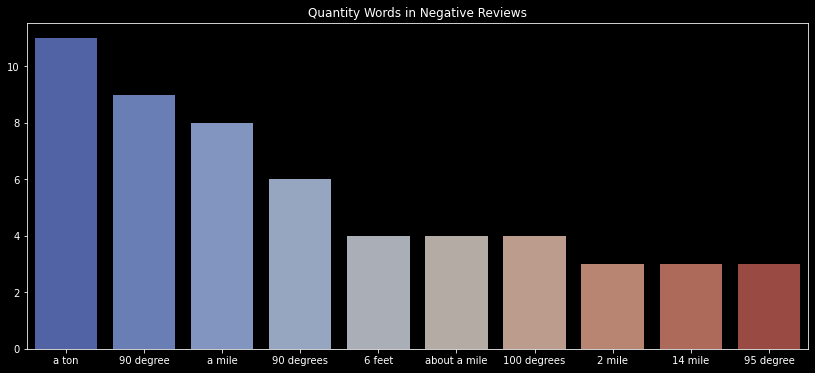

In [53]:
plt.figure(figsize=(14,6))
quantity_plot = sns.barplot(x=quantity.index, y=quantity.values, alpha=0.8, palette='coolwarm')
plt.title('Quantity Words in Negative Reviews')
plt.show()

**Check "90 degree" in negative review**

In [54]:
df_copy_text['quantity_count'] = df_copy_text['clean_review_text'].apply(lambda word:word.count('90 degree'))
df_quantity_entity = df_copy_text[df_copy_text['quantity_count']>0].sort_values(by='quantity_count', ascending=False).head(10)
df_quantity_entity

,clean_review_text,sentiment,time_count,money_count,quantity_count
42,i am in universal studios right now standing i...,positive,0,0,1
336,we spent three days at universal with a 16 and...,positive,0,0,1
19420,summer vacation with the kids half a week at o...,positive,0,0,1
19715,my family of five kids ages 18 15 and 10 took ...,positive,0,0,1
20313,we have an excellent time at universal studios...,positive,0,0,1
20367,this was our first visit to universal our grou...,positive,0,0,1
21013,those seeking thrill should head straight for ...,negative,0,0,1
22559,if you want a fun filled full day then a visit...,positive,0,0,1
22588,let me first get this out of the way yes it is...,positive,0,0,1
22876,after nearly 8 hours at islands of adventures ...,positive,0,0,1


In [55]:
df_quantity_entity['clean_review_text'].values[0:1]

array(['i am in universal studios right now standing in an outside line it is 90 degrees here the wait is 70 minutes long and they just broadcasted an announcement that for everyone is safety no eating or drinking is permitted while in line please keep your face covering over your mouth and nose at all times meanwhile we are standing in the sun dripping in sweat and the lines are socially distanced '],
      dtype=object)

>**Still the same as other negative reviews, visitors feel disturbed by long line. Plus the temperature outside is around 90 degrees and the management only broadcasted an announcement that for everyone is safety no eating or drinking is permitted while in line**

### Norp Words

In [56]:
norp = word_entity[word_entity['Entity']=='NORP']['Word'].value_counts().head(10)
norp

american    49
japanese     2
chinese      1
759pm        1
Name: Word, dtype: int64

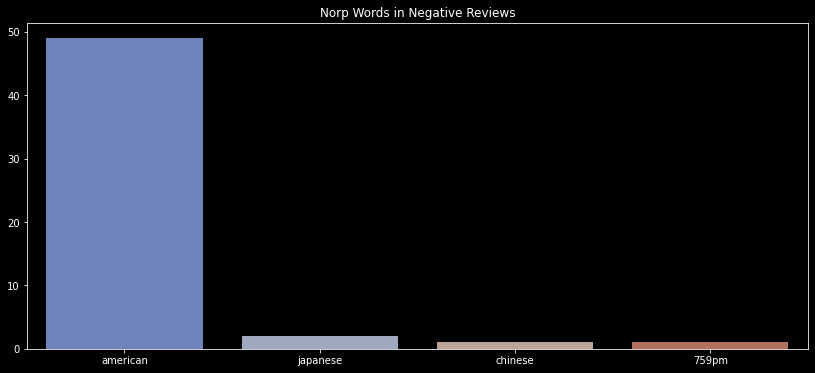

In [57]:
plt.figure(figsize=(14,6))
norp_plot = sns.barplot(x=norp.index, y=norp.values, alpha=0.8, palette='coolwarm')
plt.title('Norp Words in Negative Reviews')
plt.show()

**Check "american" in negative review**

In [58]:
df_copy_text['norp_count'] = df_copy_text['clean_review_text'].apply(lambda word:word.count('american'))
df_norp_entity = df_copy_text[df_copy_text['norp_count']>0].sort_values(by='norp_count', ascending=False).head(10)
df_norp_entity

,clean_review_text,sentiment,time_count,money_count,quantity_count,norp_count
2514,my wife and i just spent five days at universa...,positive,0,0,0,6
38738,i am a theme park nerd and i travel to parks a...,positive,0,0,0,4
9220,the first day we went we were bombarded by the...,positive,0,0,0,3
14009,i will be the 1st to say disneyuniversalisland...,positive,0,0,0,3
41300,we arrived early and joined the line to enterw...,positive,0,0,0,3
48020,its a place to visit if you are in a family ho...,positive,0,0,0,2
34234,as someone who has live in japan for 2 years g...,positive,0,0,0,2
13994,we just visited universal studios in florida a...,positive,0,0,0,2
47837,although much much smaller than it is american...,positive,0,0,0,2
13258,i have used the vip services at universal 3 ti...,positive,0,0,0,2


In [59]:
df_norp_entity['clean_review_text'].values[2:3]

array(['the first day we went we were bombarded by the american express people who are located just past security into the park area we thought hey why not sign up to get free express passes awesome right nope my wife got approved but the passes we were given did not work for our day in ioa we had a four day pass for both ioa and us so the next day when we came back we went to the american express booth were we originally got the passes and explained that the passes they gave us were bogus they stated they could not do anything we went to customer service at universal and they were extremely pleasant to deal with and were upset that ae did not rectify their mistake they are not affiliated with universal the female customer service agent stated to fix the mistake made by ae she gave us all unlimited express passes for the day it was a hot busy day made it so much easier with these passes thanks to the customer service agent who works for universal american express on the other hand do n

## Conclusion

From the analysis carried out there are many insights that we can take. Among them:
1. Highest number of visitors at Universal Studios Florida
2. From 2011 there was an increase in the number of visitors until 2016. After that, the number of visitors decreased drastically in 2020, considering that this year covid pandemic was spreading all over the world.
3. Many reviewers gave 5 stars. This means that the average Universal Studio visitor is satisfied with their visit by giving a 5 rating.
<br>
<br>
Besides analysis based on visualization, here we also get insights for word analysis on negative reviews. We first group it into several entities. From the analysis conducted, the majority of negative reviews contain a crowded atmosphere and cause long lines for each place. With such a situation, visitors feel that they are not worth the money they spend with the bad facilities they get.<br>
For the management, it is better to pay more attention to the most crowded places and make a decent line so that visitors will feel more comfortable even though they have to line for a long time.